In [ ]:
!pip install graphviz

# Importing Libraries

In [93]:
import pandas as pd
import numpy as np
import random as rn

import matplotlib.pyplot as plt
import seaborn as sns
import graphviz 
import IPython
from IPython.display import display

import re,copy,itertools

from sklearn.metrics import accuracy_score,confusion_matrix,f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz

In [2]:
import sys,types,pip

from botocore.client import Config
import ibm_boto3

# Helping functions

In [3]:
def plot_fi(fi,figsize=(12,7)): return fi.plot('cols', 'imp', 'barh', figsize=figsize, legend=False)

In [4]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [75]:
def split_balanced(data,target,val_size,shuffle=False):
    "This function split the dataset preserving the val_size ration for each class."
    idx_tr = []
    idx_val = []
    data.reset_index(inplace=True,drop=True)
    
    labels = data[target].unique().tolist()
    
    for i in labels: 
        X_class = data[data[target] == i].index.tolist()

        if shuffle: rn.shuffle(X_class)

        length = len(X_class)

        split = int(val_size * length)

        idx_val += X_class[-split:]
        idx_tr += X_class[:-split]
    
    return data.iloc[idx_tr,:],data.iloc[idx_val,:]

In [91]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [5]:
def under_samp(data,target):
    """This function does an undersampling on the class with marjority number of samples [label = 0]

    returns: undesample dataframe
    """
    data.reset_index(drop=True,inplace=True)
    
    # Number of data points in the minority class
    number_records_fraud = len(data[data[target] == 1])
    fraud_indices = np.array(data[data[target] == 1].index)

    # Picking the indices of the normal classes
    normal_indices = data[data[target] == 0].index

    # Out of the indices we picked, randomly select "x" number (number_records_fraud)
    random_normal_indices = np.random.choice(normal_indices, number_records_fraud, replace = False)
    random_normal_indices = np.array(random_normal_indices)

    # Appending the 2 indices
    under_sample_indices = np.concatenate([fraud_indices,random_normal_indices])

    # Under sample dataset
    undersamp = data.iloc[under_sample_indices,:].copy()

    return undersamp

In [6]:
def draw_tree(t, df,cls, size=10, ratio=0.6, precision=0):
    """ Draws a representation of a random forest in IPython.

    Parameters:
    -----------
    t: The tree you wish to draw
    df: The data used to train the tree. This is used to get the names of the features.
    cls = Class names
    """
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True,class_names=cls,
                      special_characters=True, rotate=True, precision=precision)
    IPython.display.display(graphviz.Source(re.sub("Tree {",
      "Tree { size="+ str(size) + "; ratio=" + str(ratio), s)))

In [7]:
if not('ibm-cos-sdk' in [package.project_name for package in pip.get_installed_distributions()]):
    !pip install ibm-cos-sdk==2.0.0 -q

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.


# Problem description 

The problem treated on this notebook refers to a Kaggle competition called [Don't Get Kicked!](https://www.kaggle.com/c/DontGetKicked).

One of the biggest challenges of an auto dealership purchasing a used car at an auto auction is the risk of that the vehicle might have serious issues that prevent it from being sold to customers. The auto community calls these unfortunate purchases "kicks".

Kicked cars often result when there are tampered odometers, mechanical issues the dealer is not able to address, issues with getting the vehicle title from the seller, or some other unforeseen problem. Kick cars can be very costly to dealers after transportation cost, throw-away repair work, and market losses in reselling the vehicle.

# Importing data

In [8]:
body = client_eb9f0afa572247dc9a4034e29c2a0bf5.get_object(Bucket='workshoppuc-donotdelete-pr-1779uskw1dylpk',Key='training.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

train = pd.read_csv(body)

In [9]:
body = client_eb9f0afa572247dc9a4034e29c2a0bf5.get_object(Bucket='workshoppuc-donotdelete-pr-1779uskw1dylpk',Key='test.csv')['Body']

# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

test = pd.read_csv(body)

In [10]:
body = client_eb9f0afa572247dc9a4034e29c2a0bf5.get_object(Bucket='workshoppuc-donotdelete-pr-1779uskw1dylpk',Key='Carvana_Data_Dictionary-1.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

dic = pd.read_csv(body,sep=';')

In [11]:
train.head()

,RefId,IsBadBuy,PurchDate,Auction,VehYear,VehicleAge,Make,Model,Trim,SubModel,...,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,PRIMEUNIT,AUCGUART,BYRNO,VNZIP1,VNST,VehBCost,IsOnlineSale,WarrantyCost
0,1,0,12/7/2009,ADESA,2006,3,MAZDA,MAZDA3,i,4D SEDAN I,...,11597.0,12409.0,NaN,NaN,21973,33619,FL,7100.0,0,1113
1,2,0,12/7/2009,ADESA,2004,5,DODGE,1500 RAM PICKUP 2WD,ST,QUAD CAB 4.7L SLT,...,11374.0,12791.0,NaN,NaN,19638,33619,FL,7600.0,0,1053
2,3,0,12/7/2009,ADESA,2005,4,DODGE,STRATUS V6,SXT,4D SEDAN SXT FFV,...,7146.0,8702.0,NaN,NaN,19638,33619,FL,4900.0,0,1389
3,4,0,12/7/2009,ADESA,2004,5,DODGE,NEON,SXT,4D SEDAN,...,4375.0,5518.0,NaN,NaN,19638,33619,FL,4100.0,0,630
4,5,0,12/7/2009,ADESA,2005,4,FORD,FOCUS,ZX3,2D COUPE ZX3,...,6739.0,7911.0,NaN,NaN,19638,33619,FL,4000.0,0,1020


# Data Preparation

## Treating missing values

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72983 entries, 0 to 72982
Data columns (total 34 columns):
RefId                                72983 non-null int64
IsBadBuy                             72983 non-null int64
PurchDate                            72983 non-null object
Auction                              72983 non-null object
VehYear                              72983 non-null int64
VehicleAge                           72983 non-null int64
Make                                 72983 non-null object
Model                                72983 non-null object
Trim                                 70623 non-null object
SubModel                             72975 non-null object
Color                                72975 non-null object
Transmission                         72974 non-null object
WheelTypeID                          69814 non-null float64
WheelType                            69809 non-null object
VehOdo                               72983 non-null int64
Nationalit

In [13]:
round((train.isnull().sum()/train.shape[0])*100,3)

RefId                                 0.000
IsBadBuy                              0.000
PurchDate                             0.000
Auction                               0.000
VehYear                               0.000
VehicleAge                            0.000
Make                                  0.000
Model                                 0.000
Trim                                  3.234
SubModel                              0.011
Color                                 0.011
Transmission                          0.012
WheelTypeID                           4.342
WheelType                             4.349
VehOdo                                0.000
Nationality                           0.007
Size                                  0.007
TopThreeAmericanName                  0.007
MMRAcquisitionAuctionAveragePrice     0.025
MMRAcquisitionAuctionCleanPrice       0.025
MMRAcquisitionRetailAveragePrice      0.025
MMRAcquisitonRetailCleanPrice         0.025
MMRCurrentAuctionAveragePrice   

In [14]:
dic[dic['Field Name']=='AUCGUART']['Definition'].values

array([ 'The level aguarntee provided by auction for the vehicle (Green light - Guaranteed/arbitratable, Yellow Light - caution/issue, red light - sold as is)'], dtype=object)

In [15]:
train.drop(columns=['PRIMEUNIT','AUCGUART'],inplace=True)
train.shape

(72983, 32)

Percentage of rows with no nulls

In [16]:
(train.dropna().shape[0]/train.shape[0])*100

92.17214967869229

Common strategies for treating missing values depends on the type of the data. 
- Categorical: Most frequent;
- Numerical: Average, Median, Max.

**Let's try to fix the TRIM missing values instead of just dropping**

In [17]:
dic[dic['Field Name']=='Trim']['Definition'].values

array(['Vehicle Trim Level'], dtype=object)

In [18]:
train['Trim'].value_counts()

Bas    13950
LS     10174
SE      9348
SXT     3825
LT      3540
LX      2417
Tou     2256
EX      2120
SEL     1360
XLT     1357
GLS     1355
Spo     1254
SLT     1200
Lim      965
Lar      902
ST       841
GT       808
XLS      772
2        765
ES       700
S        630
ZX4      606
SES      601
LE       572
SLE      543
i        487
Cla      475
Nor      448
XL       448
GL       410
       ...  
Cin        7
ZTW        7
GX         7
RT         7
RS         6
Den        6
Spe        5
Ove        5
Ral        4
eC         4
Ent        4
ZR2        4
GXP        3
250        3
Car        3
Hyb        3
Si         3
XS         2
T5         2
Dur        2
L 3        1
Ult        1
LL         1
Xsp        1
Z24        1
JLX        1
Out        1
JLS        1
Maz        1
Har        1
Name: Trim, Length: 134, dtype: int64

Trim is a submodel of a Car

In [19]:
train[train['Model']=='IMPALA'].groupby(by=['SubModel'])['Trim'].unique()

SubModel
4D SEDAN            [Bas]
4D SEDAN LS          [LS]
4D SEDAN LT 3.5L     [LT]
4D SEDAN LT 3.9L     [LT]
4D SEDAN LTZ        [LTZ]
4D SEDAN SS          [SS]
Name: Trim, dtype: object

Let's take all indexes of null values on the column `Trim`

In [20]:
idx_n = train[train['Trim'].isnull()].index.values
idx_n.shape

(2360,)

In [21]:
train['Trim'].isnull().sum()

2360

The next cell go for each idx with null values of Trim and select the model and submodel of that row. With this information, it is made a query on the dataset searching for this model and submodel discarting the null elements of `Trim`. The query returns the most frequent value of `Trim`. 

This value is then put in place of the Null `Trim` element of the index of the for loop iteration.

In [22]:
idxs =[]
for i in idx_n: 
    model,s_model = train.loc[i,['Model','SubModel']].values


    trim = train[(train['Model']==model)&
                 (train['SubModel']==s_model)&
                 (train['Trim'].notnull())]['Trim'].mode()
    
    if trim.shape[0] >=1:
        train.at[i,'Trim'] = trim.values[0]
    else: 
        idxs.append(i)

We can see that it was possible to save 1482 elements

In [23]:
2360 - len(idxs)

1482

In [24]:
train['Trim'].isnull().sum()

878

With this simple strategy we could recover roughly 2% of the data. 

In [25]:
(train.dropna().shape[0]/train.shape[0])*100

94.08766425057891

Now let's drop the rest of the null values

In [26]:
train.dropna(inplace=True)

In [27]:
train.shape

(68668, 32)

In [28]:
train.isnull().sum().sum()

0

# Data Exploration

In [29]:
train.columns

Index(['RefId', 'IsBadBuy', 'PurchDate', 'Auction', 'VehYear', 'VehicleAge',
       'Make', 'Model', 'Trim', 'SubModel', 'Color', 'Transmission',
       'WheelTypeID', 'WheelType', 'VehOdo', 'Nationality', 'Size',
       'TopThreeAmericanName', 'MMRAcquisitionAuctionAveragePrice',
       'MMRAcquisitionAuctionCleanPrice', 'MMRAcquisitionRetailAveragePrice',
       'MMRAcquisitonRetailCleanPrice', 'MMRCurrentAuctionAveragePrice',
       'MMRCurrentAuctionCleanPrice', 'MMRCurrentRetailAveragePrice',
       'MMRCurrentRetailCleanPrice', 'BYRNO', 'VNZIP1', 'VNST', 'VehBCost',
       'IsOnlineSale', 'WarrantyCost'],
      dtype='object')

## What models were often sold as a BadBuy?

In [30]:
train['PurchDate'] = pd.to_datetime(train['PurchDate'],infer_datetime_format=True)
train['PurchDate'].describe()

count                   68668
unique                    516
top       2010-11-23 00:00:00
freq                      362
first     2009-01-05 00:00:00
last      2010-12-30 00:00:00
Name: PurchDate, dtype: object

In [31]:
tmp = train.groupby(['Model',pd.Grouper(key='PurchDate',freq='Q')])['IsBadBuy'].sum().reset_index()
tmp.head(3)

,Model,PurchDate,IsBadBuy
0,1500 RAM PICKUP 2WD,2009-03-31,14
1,1500 RAM PICKUP 2WD,2009-06-30,5
2,1500 RAM PICKUP 2WD,2009-09-30,10


In [32]:
Qs = pd.to_datetime(tmp['PurchDate'].unique())

In [33]:
models = []
for q in Qs: 
    idx = tmp[tmp['PurchDate']==q]['IsBadBuy'].idxmax()
    models.append(tmp.loc[idx,:].values)

In [34]:
models = pd.DataFrame(models,columns=tmp.columns.tolist())

models

,Model,PurchDate,IsBadBuy
0,TAURUS 3.0L V6 EFI,2009-03-31,57
1,TAURUS 3.0L V6 EFI,2009-06-30,31
2,TAURUS 3.0L V6 EFI,2009-09-30,34
3,PT CRUISER,2009-12-31,37
4,PT CRUISER,2010-03-31,61
5,PT CRUISER,2010-06-30,66
6,PT CRUISER,2010-09-30,69
7,PT CRUISER,2010-12-31,89


In [35]:
models['PurchDate'] = pd.to_datetime(models['PurchDate'],infer_datetime_format=True)
models['Q-Y'] =  'Q'+models.PurchDate.dt.quarter.astype(str)+ '-' + models.PurchDate.dt.year.apply(lambda x: str(x)[-2:])
models['Q-Y']

0    Q1-09
1    Q2-09
2    Q3-09
3    Q4-09
4    Q1-10
5    Q2-10
6    Q3-10
7    Q4-10
Name: Q-Y, dtype: object

/opt/ibm/conda/miniconda3/lib/python3.5/site-packages/seaborn/categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


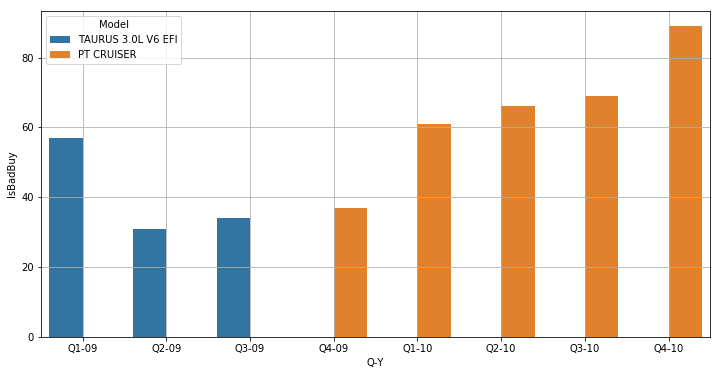

In [36]:
plt.figure(figsize=(12,6))
sns.barplot(x=models['Q-Y'],y=models['IsBadBuy'],hue=models['Model'])
plt.grid()
plt.show()

## What about the manufacturer? 

In [37]:
train['Make'].value_counts()

CHEVROLET       16529
DODGE           12408
FORD            10710
CHRYSLER         8120
PONTIAC          3923
KIA              2325
NISSAN           1970
SATURN           1933
HYUNDAI          1710
JEEP             1555
SUZUKI           1204
TOYOTA           1102
MITSUBISHI        968
MAZDA             887
MERCURY           792
BUICK             676
GMC               623
HONDA             469
OLDSMOBILE        224
ISUZU             130
VOLKSWAGEN        119
SCION             113
VOLVO              37
LINCOLN            31
SUBARU             25
MINI               24
ACURA              23
CADILLAC           21
INFINITI           13
PLYMOUTH            2
LEXUS               1
TOYOTA SCION        1
Name: Make, dtype: int64

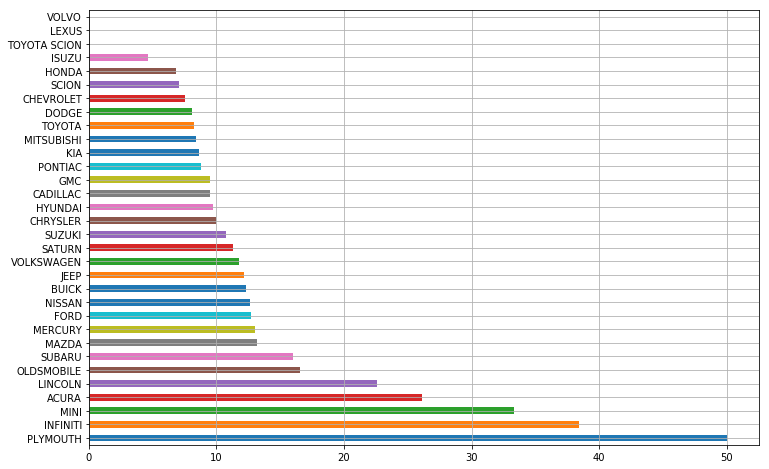

In [38]:
tmp = round((train[train['IsBadBuy']==1]['Make'].value_counts()/train['Make'].value_counts())*100,2)
tmp.fillna(0.,inplace=True)
tmp.sort_values(ascending=False,inplace=True)
tmp.plot(kind='barh',grid=True,figsize=(12,8))

## What about the Age of the Vehicles ? 

In [39]:
train['VehicleAge'].describe()

count    68668.000000
mean         4.154453
std          1.703108
min          0.000000
25%          3.000000
50%          4.000000
75%          5.000000
max          9.000000
Name: VehicleAge, dtype: float64

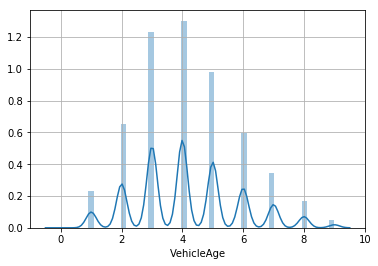

In [40]:
plt.figure()
sns.distplot(train['VehicleAge'])
plt.grid()
plt.show()

In [41]:
train['IsOld'] = np.zeros((train.shape[0],))

train.loc[train['VehicleAge']>5,'IsOld'] =1

/opt/ibm/conda/miniconda3/lib/python3.5/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


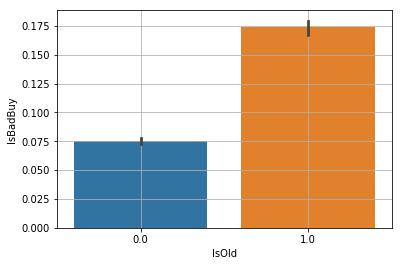

In [42]:
plt.figure()
sns.barplot(x=train['IsOld'],y=train['IsBadBuy'],estimator=np.mean)
plt.grid()
plt.show()

In [43]:
train.columns

Index(['RefId', 'IsBadBuy', 'PurchDate', 'Auction', 'VehYear', 'VehicleAge',
       'Make', 'Model', 'Trim', 'SubModel', 'Color', 'Transmission',
       'WheelTypeID', 'WheelType', 'VehOdo', 'Nationality', 'Size',
       'TopThreeAmericanName', 'MMRAcquisitionAuctionAveragePrice',
       'MMRAcquisitionAuctionCleanPrice', 'MMRAcquisitionRetailAveragePrice',
       'MMRAcquisitonRetailCleanPrice', 'MMRCurrentAuctionAveragePrice',
       'MMRCurrentAuctionCleanPrice', 'MMRCurrentRetailAveragePrice',
       'MMRCurrentRetailCleanPrice', 'BYRNO', 'VNZIP1', 'VNST', 'VehBCost',
       'IsOnlineSale', 'WarrantyCost', 'IsOld'],
      dtype='object')

# Model Development

In [44]:
target = 'IsBadBuy'

predictors = [x for x in train.columns if x not in [target,'RefId','PurchDate']]

In [45]:
predictors

['Auction',
 'VehYear',
 'VehicleAge',
 'Make',
 'Model',
 'Trim',
 'SubModel',
 'Color',
 'Transmission',
 'WheelTypeID',
 'WheelType',
 'VehOdo',
 'Nationality',
 'Size',
 'TopThreeAmericanName',
 'MMRAcquisitionAuctionAveragePrice',
 'MMRAcquisitionAuctionCleanPrice',
 'MMRAcquisitionRetailAveragePrice',
 'MMRAcquisitonRetailCleanPrice',
 'MMRCurrentAuctionAveragePrice',
 'MMRCurrentAuctionCleanPrice',
 'MMRCurrentRetailAveragePrice',
 'MMRCurrentRetailCleanPrice',
 'BYRNO',
 'VNZIP1',
 'VNST',
 'VehBCost',
 'IsOnlineSale',
 'WarrantyCost',
 'IsOld']

## Undersampling target

In [46]:
train[target].value_counts()

0    62102
1     6566
Name: IsBadBuy, dtype: int64

In [47]:
train_eq = under_samp(train,target)
train_eq[target].value_counts()

1    6566
0    6566
Name: IsBadBuy, dtype: int64

## Treating Categorical features

In [76]:
Xtrain= train_eq[predictors+[target]].copy()
Xtrain[target]= Xtrain[target].astype(int)

In [77]:
Xtrain[predictors[0]].dtype == 'O' 

True

In [78]:
mapper = {}
for col in predictors:
    
    if Xtrain[col].dtype == 'O' :

        le = LabelEncoder()
        Xtrain[col] = Xtrain[col].astype(str)
        Xtrain[col] = le.fit_transform(Xtrain[col])
        mapper[col] = copy.copy(le)
        
    else: 
        
        Xtrain[col] = Xtrain[col].astype(float)

In [79]:
mapper['Color'].classes_

array(['BEIGE', 'BLACK', 'BLUE', 'BROWN', 'GOLD', 'GREEN', 'GREY',
       'MAROON', 'NOT AVAIL', 'ORANGE', 'OTHER', 'PURPLE', 'RED', 'SILVER',
       'WHITE', 'YELLOW'], dtype=object)

In [80]:
Xtrain.shape

(13132, 31)

In [81]:
Xtrain,Xtest = split_balanced(Xtrain,target,0.2)
Xtrain[target].value_counts()

1    5253
0    5253
Name: IsBadBuy, dtype: int64

In [82]:
Xtest[target].value_counts()

1    1313
0    1313
Name: IsBadBuy, dtype: int64

## First Model

In [105]:
clf = RandomForestClassifier(n_estimators=100,max_depth=4,bootstrap=False,
                             n_jobs=-1,random_state=0)
clf.fit(Xtrain[predictors],Xtrain[target])

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

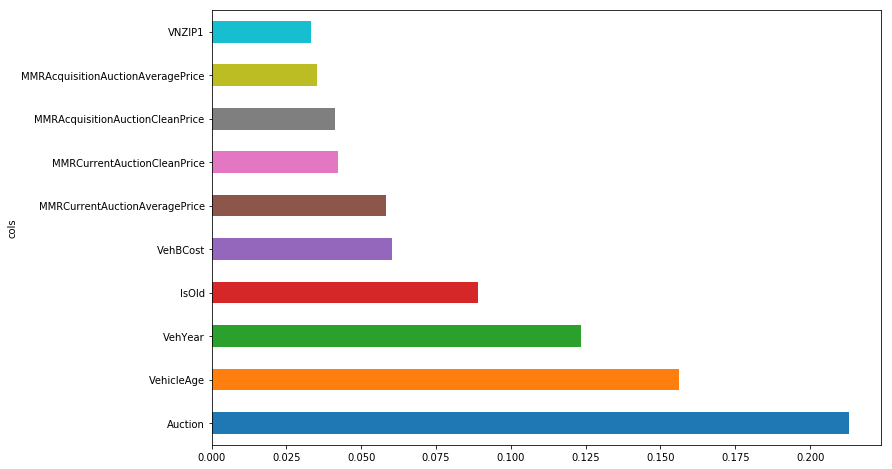

In [106]:
fi = rf_feat_importance(clf, Xtrain[predictors])
plot_fi(fi[:10],figsize=(12,8));

In [107]:
dic[dic['Field Name']=='VehOdo']['Definition'].values

array(['The vehicles odometer reading'], dtype=object)

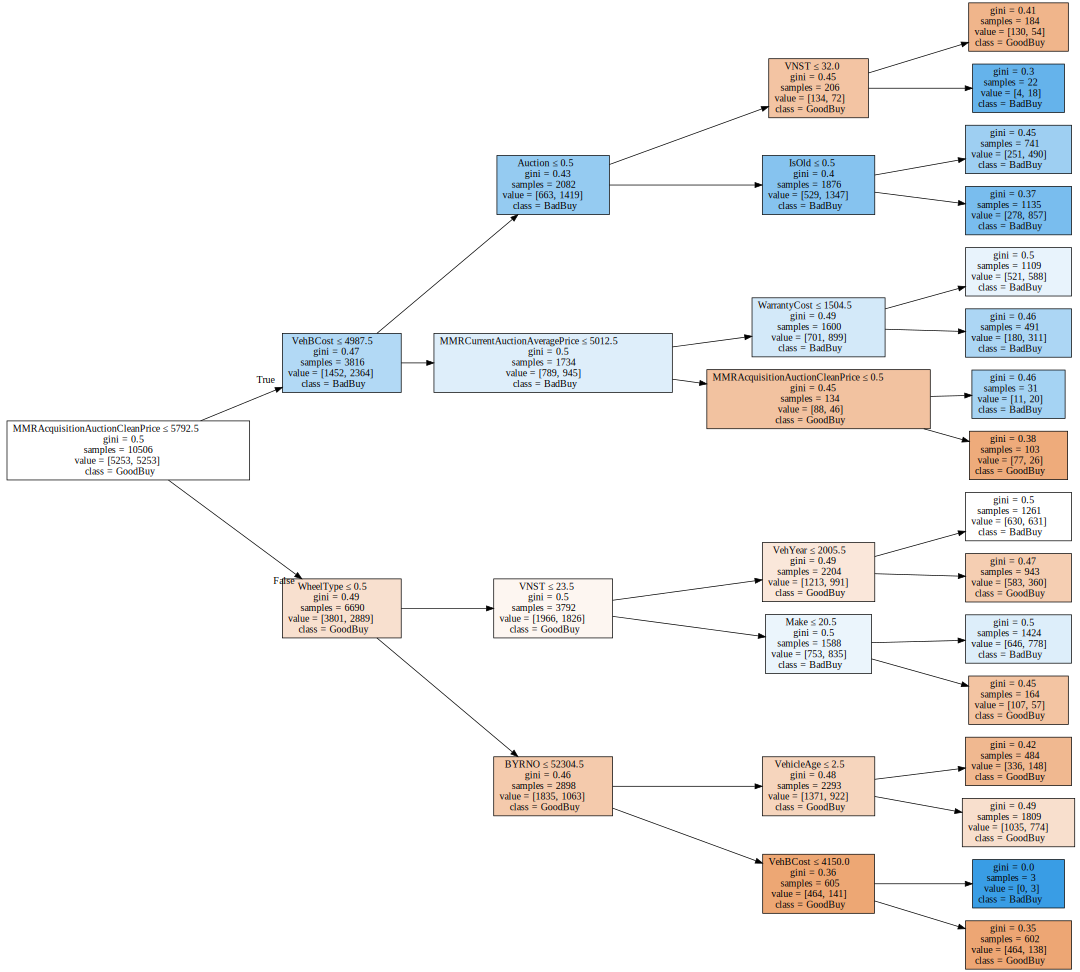

In [87]:
draw_tree(clf.estimators_[0], Xtrain[predictors],cls=['GoodBuy','BadBuy'],ratio=0.9,size=15, precision=2)

**Evaluating performance**

In [101]:
ypred = clf.predict(Xtest[predictors])

In [103]:
accuracy_score(Xtest[target],ypred),f1_score(Xtest[target],ypred)

(0.44859101294744858, 0.31244064577397906)

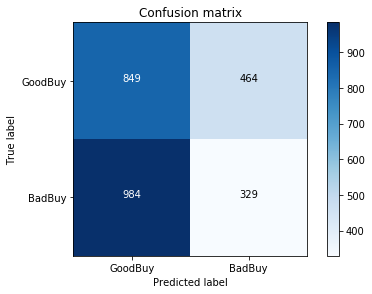

In [104]:
cnf_matrix = confusion_matrix(Xtest[target],ypred,labels=[0,1])
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=['GoodBuy','BadBuy']
                      , title='Confusion matrix')
plt.show()